<p align="center">
  <img src="sentiment.jpg">
</p>

# Twitter Sentiment Analysis

extracting subjective information from text or speech, such as opinions or attitudes or classifying a piece of text as positive, negative or neutral.<br>
this example classify racist and not racist tweets

#### Table of contents

1. Understand the Problem Statement
1. Tweets Preprocessing and Cleaning
    1. Data Inspection
    1. Data Cleaning
1. Story Generation and Visualization from Tweets
1. Extracting Features from Cleaned Tweets
    1. Bag-of-Words
    1. TF-IDF
    1. Word Embeddings
1. Model Building: Sentiment Analysis
    1. Logistic Regression
    1. Support Vector Machine
    1. RandomForest
    1. XGBoost
1. Model Fine-tuning
1. Summary

## load the libraries

In [2]:
import re    
import nltk  
import string 
import warnings 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt  
from IPython.display import display
import preprocessor as twpreprocessor
from nltk.stem.porter import PorterStemmer 
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
import gensim
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## load train and test dataset

In [3]:
train = pd.read_csv('./data/train.csv.zip',compression='zip')
test = pd.read_csv('./data/test.csv.zip',compression='zip')

print(train.info())
display(train.head())
display(train[train.label==0].head())
display(train[train.label==1].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB
None


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia


## explore data

0    29720
1     2242
Name: label, dtype: int64


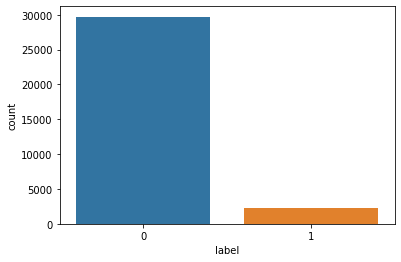

In [4]:
print(train['label'].value_counts())

sns.countplot(train.label)

### tweets distribution

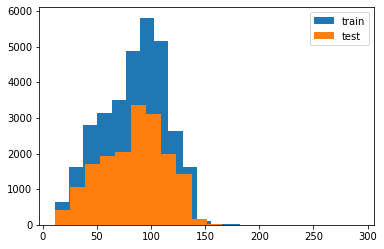

In [5]:
plt.hist(train.tweet.str.len(), bins=20, label='train')
plt.hist(test.tweet.str.len(), bins=20, label='test')
plt.legend()
plt.show()

## clean data

In [6]:
combination = train.append(test, ignore_index=True, sort=True)
combination.shape

(49159, 3)

In [7]:
twpreprocessor.set_options(twpreprocessor.OPT.EMOJI,twpreprocessor.OPT.ESCAPE_CHAR,twpreprocessor.OPT.MENTION,twpreprocessor.OPT.NUMBER,twpreprocessor.OPT.RESERVED,twpreprocessor.OPT.SMILEY,twpreprocessor.OPT.URL)
combination['tidy_tweet'] = np.vectorize(twpreprocessor.clean)(combination['tweet']) 
# Removing Short Words
combination.tidy_tweet = combination.tidy_tweet.apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))
combination.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunctional selfish drags kids into dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks #lyft credit can't cause they don't offer wheelchair vans pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time ur!!!
4,5,0.0,factsguide: society now #motivation,factsguide: society #motivation


### Text Normalization

In [8]:
tokenized_tweet = combination.tidy_tweet.apply(lambda x: x.split())
stemmer = PorterStemmer() 
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
tokenized_tweet = tokenized_tweet.apply(lambda x: ' '.join(x)) 
combination['tidy_tweet'] = tokenized_tweet
combination.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunct selfish drag kid into dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thank #lyft credit can't caus they don't offer wheelchair van pdx. #disapoint #getthank
2,3,0.0,bihday your majesty,bihday your majesti
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time ur!!!
4,5,0.0,factsguide: society now #motivation,factsguide: societi #motiv


### common words used in the tweets

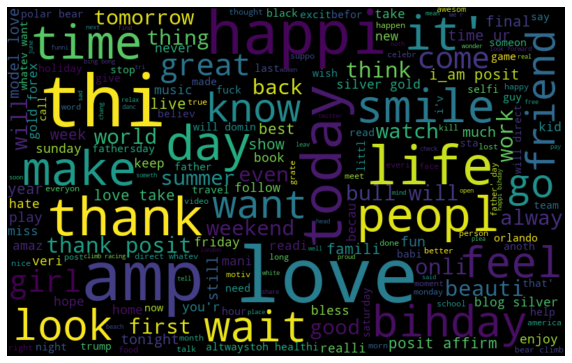

In [9]:
all_words = ' '.join([text for text in combination['tidy_tweet']]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

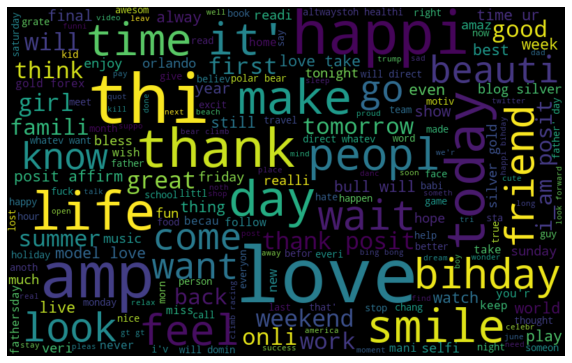

In [10]:
# Words in non racist(normal) tweets
normal_words =' '.join([text for text in combination['tidy_tweet'][combination['label'] == 0]]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

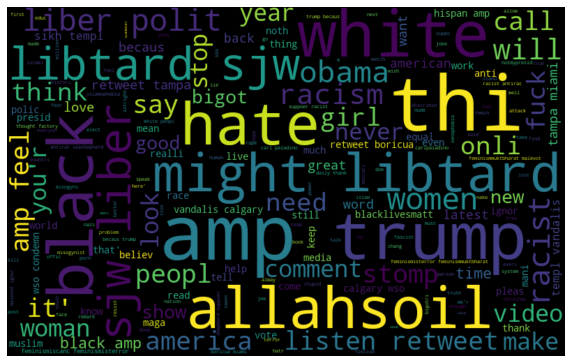

In [11]:
# Words in racist(negative) tweets
negative_words =' '.join([text for text in combination['tidy_tweet'][combination['label'] == 1]]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Understanding the impact of Hashtags on tweets sentiment

In [12]:
normal_hashtag = re.findall(r"#(\w+)",normal_words)
negative_hashtag = re.findall(r"#(\w+)",negative_words)

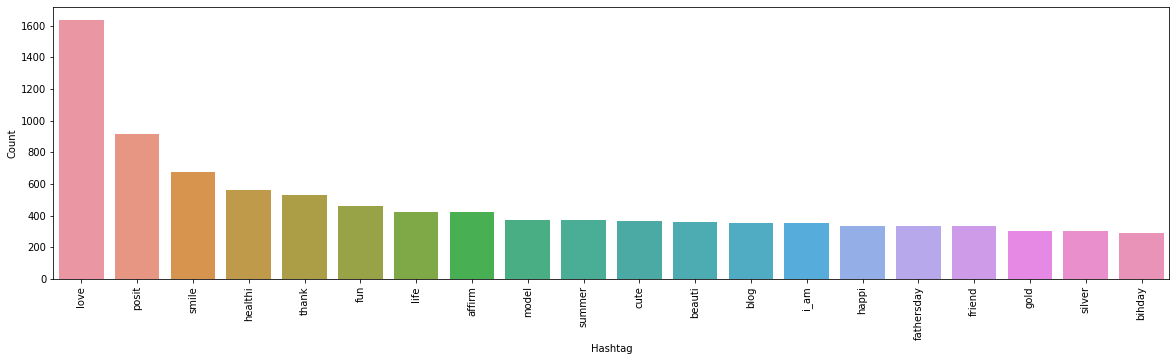

In [13]:
a = nltk.FreqDist(normal_hashtag)
d = pd.DataFrame(
    {
    'Hashtag': list(a.keys()),
    'Count': list(a.values())
    }
) 

# selecting top 20 most normal hashtags
d = d.nlargest(columns="Count", n = 20)
plt.figure(figsize=(20,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.xticks(rotation=90)
plt.show()

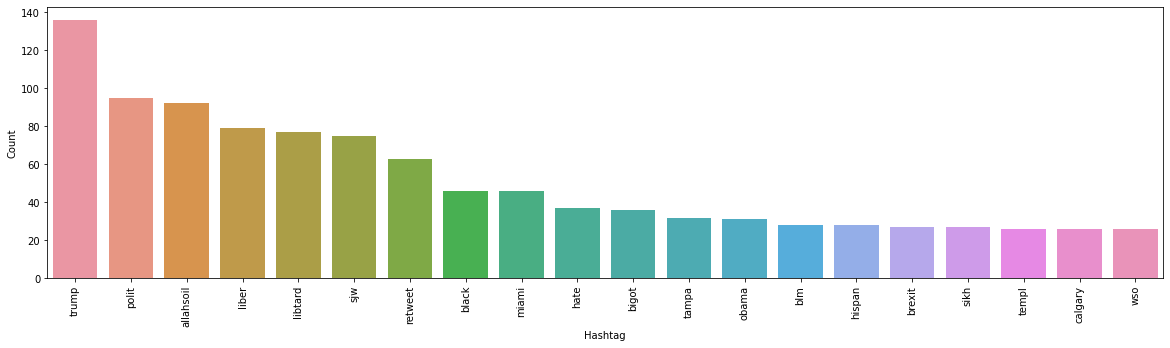

In [14]:
a = nltk.FreqDist(negative_hashtag)
d = pd.DataFrame(
    {
    'Hashtag': list(a.keys()),
    'Count': list(a.values())
    }
) 

# selecting top 20 most negative hashtags
d = d.nlargest(columns="Count", n = 20)
plt.figure(figsize=(20,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.xticks(rotation=90)
plt.show()

## feature extraction

### convert text into features (techniques):
* Bag of Words
* TF-IDF
* Word Embeddings

In [15]:
# Bag of Words
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(combination['tidy_tweet'])
bow.shape

(49159, 1000)

In [16]:
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(combination['tidy_tweet'])
tfidf.shape

(49159, 1000)

In [17]:
# Word2Vec
tokenized_tweet = combination['tidy_tweet'].apply(lambda x: x.split()) # tokenizing 

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 32, # no.of cores
            seed = 34
) 

model_w2v.train(tokenized_tweet, total_examples= len(combination['tidy_tweet']), epochs=20)

(6560244, 7893520)

In [18]:
model_w2v.wv.most_similar(positive="dinner")

[('spaghetti', 0.6478804349899292),
 ('shopping!', 0.6174654364585876),
 ('#biall2016', 0.608840823173523),
 ('enrout', 0.6041078567504883),
 ('sister!!', 0.6037885546684265),
 ('friend...', 0.6028569340705872),
 ('#prosecco', 0.5898137092590332),
 ('#avocado', 0.5890375971794128),
 ('#bihdaydinn', 0.5861620903015137),
 ('sushi', 0.5860233902931213)]

In [20]:
model_w2v.most_similar(positive="trump")

[('fraud.', 0.5733660459518433),
 ('suppoer.', 0.5718240737915039),
 ('donald', 0.558451771736145),
 ('phony.', 0.5563092231750488),
 ('sexist.', 0.5563082098960876),
 ('#delegaterevolt', 0.5498700141906738),
 ('rally.', 0.5492333769798279),
 ('churchil', 0.5486605167388916),
 ('businessman:', 0.5471241474151611),
 ('presidential.', 0.5465004444122314)]

In [21]:
model_w2v['food']

array([-7.92983398e-02,  9.33198214e-01, -1.93108499e-01,  6.39527321e-01,
       -2.13952646e-01, -1.14290282e-01, -6.55258060e-01, -1.42931357e-01,
        7.79822111e-01, -3.22749645e-01,  4.16244179e-01, -2.42113695e-02,
       -3.04729402e-01, -3.43582243e-01, -2.86119759e-01, -3.02453965e-01,
        1.45008877e-01, -3.23514491e-01, -1.27363309e-01,  3.42417151e-01,
        6.23101115e-01, -1.97674632e-01, -8.87196302e-01, -6.95215762e-01,
        3.34577441e-01, -3.62170875e-01, -1.61266327e-01,  3.34045023e-01,
       -6.79982901e-01, -1.26299679e+00,  3.14780511e-02, -2.83240192e-02,
        3.04157257e-01,  5.81308544e-01,  2.46203184e-01, -3.61694470e-02,
        3.05929452e-01,  3.29503119e-01,  3.57926823e-02,  9.26987886e-01,
       -3.32352705e-02,  2.18546972e-01, -7.95899570e-01, -4.39203203e-01,
       -3.04004282e-01,  1.00384474e+00,  8.18799715e-03,  4.20575529e-01,
        2.16115594e-01,  6.94143325e-02, -1.09757180e-04, -4.19509351e-01,
       -3.77721369e-01, -

In [22]:
len(model_w2v['food']) 

200

In [23]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

wordvec_arrays = np.zeros((len(tokenized_tweet), 200)) 
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(49159, 200)

## Building models

### Algorithms
1. Logistic Regression
1. Support Vector Machine
1. RandomForest
1. XGBoost

** *Logistic Regression / Bag of Words* **

In [25]:
# Extracting train and test BoW features 
train_bow = bow[:31962,:] 
test_bow = bow[31962:,:] 

# splitting data into training and validation set 
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'], random_state=42, test_size=0.3)

lreg = LogisticRegression(solver='lbfgs') 

# training the model 
lreg.fit(xtrain_bow, ytrain) 
prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set 
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0 
prediction_int = prediction_int.astype(np.int) 
print('[Logistic Regression / Bag of Words] f1 score: ',f1_score(yvalid, prediction_int)) # calculating f1 score for the validation set

# prediction using bow-logreg model
test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['id','label']]
submission.to_csv('result/lreg_bow.csv', index=False) # writing data to a CSV file

[Logistic Regression / Bag of Words] f1 score:  0.5368682684341342


** *Logistic Regression / TF-IDF* **

In [27]:
# tf-idf_logreg
train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:] 

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain) 

prediction = lreg.predict_proba(xvalid_tfidf)

prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int) 

print('[Logistic Regression / TF-IDF] f1 score: ',f1_score(yvalid, prediction_int)) # calculating f1 score for the validation set

[Logistic Regression / TF-IDF] f1 score:  0.5347405452946349


** *Logistic Regression / Wrod2Vec* **

In [28]:
# word2vec_logreg
train_w2v = wordvec_df.iloc[:31962,:]
test_w2v = wordvec_df.iloc[31962:,:]

xtrain_w2v = train_w2v.iloc[ytrain.index,:]
xvalid_w2v = train_w2v.iloc[yvalid.index,:]

lreg.fit(xtrain_w2v, ytrain) 

prediction = lreg.predict_proba(xvalid_w2v)

prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

print('[Logistic Regression / Word2Vec] f1 score: ',f1_score(yvalid, prediction_int)) # calculating f1 score for the validation set

[Logistic Regression / Word2Vec] f1 score:  0.5903614457831327


** *SVM / Bag Of Words* **

In [29]:
# svm_bow
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_bow, ytrain) 
prediction = svc.predict_proba(xvalid_bow) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
print('[SVM / Bag Of Words] f1 score: ',f1_score(yvalid, prediction_int)) # calculating f1 score for the validation set

[SVM / Bag Of Words] f1 score:  0.5133394664213431


** *SVM / TF-IDF* **

In [30]:
# svm_tf-idf
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_tfidf, ytrain) 
prediction = svc.predict_proba(xvalid_tfidf) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
print('[SVM / TF-IDF] f1 score: ',f1_score(yvalid, prediction_int)) # calculating f1 score for the validation set

[SVM / TF-IDF] f1 score:  0.5045871559633027


** *SVM / Word2Vec* **

In [31]:
# svm_word2vec
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_w2v, ytrain) 
prediction = svc.predict_proba(xvalid_w2v) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
print('[SVM / Word2Vec] f1 score: ',f1_score(yvalid, prediction_int)) # calculating f1 score for the validation set

[SVM / Word2Vec] f1 score:  0.5934242181234964


** *Random Forest / Bag Of Words* **

In [35]:
# RandomForest_bow
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_bow, ytrain) 
prediction = rf.predict(xvalid_bow) 
print('[Random Forest / Bag Of Words] f1 score: ',f1_score(yvalid, prediction)) # calculating f1 score for the validation set

[Random Forest / Bag Of Words] f1 score:  0.5112179487179487


** *Random Forest / TF-IDF* **

In [36]:
# RandomForest_tf-idf
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_tfidf, ytrain) 
prediction = rf.predict(xvalid_tfidf)
print('[Random Forest / TF-IDF] f1 score: ',f1_score(yvalid, prediction)) # calculating f1 score for the validation set

[Random Forest / TF-IDF] f1 score:  0.5393883225208527


** *Random Forest / Word2Vec* **

In [37]:
# RandomForest_word2vec
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_w2v, ytrain) 
prediction = rf.predict(xvalid_w2v)
print('[Random Forest / Word2Vec] f1 score: ',f1_score(yvalid, prediction)) 

[Random Forest / Word2Vec] f1 score:  0.4881209503239741


** *XGBoost / Bag Of Words* **

In [39]:
# xgboost_bow
xgb_model = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_bow, ytrain)
prediction = xgb_model.predict(xvalid_bow)
print('[XGBoost / Bag Of Words] f1 score: ',f1_score(yvalid, prediction)) 

[XGBoost / Bag Of Words] f1 score:  0.5228519195612431


** *XGBoost / TF-IDF* **

In [40]:
# xgboost_tf-idf
xgb = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_tfidf, ytrain) 
prediction = xgb.predict(xvalid_tfidf)
print('[XGBoost / TF-IDF] f1 score: ',f1_score(yvalid, prediction)) 

[XGBoost / TF-IDF] f1 score:  0.5390199637023594


** *XGBoost / Word2Vec* **

In [41]:
# xgboost_w2v
xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(xtrain_w2v, ytrain) 
prediction = xgb.predict(xvalid_w2v)
print('[XGBoost / Word2Vec] f1 score: ',f1_score(yvalid, prediction)) 

[XGBoost / Word2Vec] f1 score:  0.6378378378378379
